In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

#Buscamos: prediccion de series de tiempo de la calidad del 
#aire por provincia y por estacion 
#Tareas: EDA, Regresion de series de tiempo ARMA/ARIMA

In [2]:
datos = pd.read_csv('aire.csv', sep = ';', index_col = 0, parse_dates = True)
#, header = None, skiprows=[0]
datos.head()

/home/sandy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CO (mg/m3),NO (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),SH2 (ug/m3),PM25 (ug/m3),PST (ug/m3),SO2 (ug/m3),PROVINCIA,ESTACIÓN
DIA,,,,,,,,,,,
1997-01-01,1.2,12,33,63,56,NaN,NaN,NaN,19,ÁVILA,Ávila
1997-02-01,1.3,15,35,59,47,NaN,NaN,NaN,17,ÁVILA,Ávila
1997-03-01,1.5,18,43,54,65,NaN,NaN,NaN,19,ÁVILA,Ávila
1997-04-01,1.6,56,73,50,74,NaN,NaN,NaN,22,ÁVILA,Ávila
1997-05-01,1.4,11,33,63,54,NaN,NaN,NaN,18,ÁVILA,Ávila


In [3]:
#Para el calculo solo se tomarán en cuenta los gases
#que se pueden medir en la escala del IMECA O3,NO2,SO2,CO,PM10 Y PM2.5
#Se removeran NO, SH2 Y PST
datos = datos.drop(['NO (ug/m3)','SH2 (ug/m3)', 'PST (ug/m3)'],  axis=1 )
datos.head()


,CO (mg/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),PROVINCIA,ESTACIÓN
DIA,,,,,,,,
1997-01-01,1.2,33,63,56,NaN,19,ÁVILA,Ávila
1997-02-01,1.3,35,59,47,NaN,17,ÁVILA,Ávila
1997-03-01,1.5,43,54,65,NaN,19,ÁVILA,Ávila
1997-04-01,1.6,73,50,74,NaN,22,ÁVILA,Ávila
1997-05-01,1.4,33,63,54,NaN,18,ÁVILA,Ávila


In [4]:
#Se remplaza leyenda "No cumple el anexo IV de la Decisión del Consejo 97/101/CE" por NaN
for i in datos:
    datos[i].replace("No cumple el anexo IV de la Decisión del Consejo 97/101/CE",np.NaN, inplace=True)
datos.head()

,CO (mg/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),PROVINCIA,ESTACIÓN
DIA,,,,,,,,
1997-01-01,1.2,33,63,56,NaN,19,ÁVILA,Ávila
1997-02-01,1.3,35,59,47,NaN,17,ÁVILA,Ávila
1997-03-01,1.5,43,54,65,NaN,19,ÁVILA,Ávila
1997-04-01,1.6,73,50,74,NaN,22,ÁVILA,Ávila
1997-05-01,1.4,33,63,54,NaN,18,ÁVILA,Ávila


In [5]:
#Debido a que el indice de la calidad del aire se calcula solo con el gas de mas concentracion,
#los NaN se remplazarán por 0.
datos.fillna(0, inplace=True)
datos.head()

,CO (mg/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),PROVINCIA,ESTACIÓN
DIA,,,,,,,,
1997-01-01,1.2,33,63,56,0,19,ÁVILA,Ávila
1997-02-01,1.3,35,59,47,0,17,ÁVILA,Ávila
1997-03-01,1.5,43,54,65,0,19,ÁVILA,Ávila
1997-04-01,1.6,73,50,74,0,22,ÁVILA,Ávila
1997-05-01,1.4,33,63,54,0,18,ÁVILA,Ávila


In [6]:
#Los datos de la concentración de O3, NO2, SO2 y CO están expresados en
#mili y micro gramos por metro cúbico, pero, para calcular la calidad del aire según IMECA,
#tenemos que cambiarlos a partes por millón.
#Estos son los factores de conversión si se considera como condiciones de referencia(Temperatura a 25C y
#101 kilopascales) las estipuladas en la Norma Ambiental del Distrito Federal NADF-009-AIRE-2006 en
#la cual se fundamenta el IMECA:
#CO 1 ppb = 1.145 µg/m3
#NO2 1 ppb = 1.88 µg/m3
#O3 1 ppb = 2.00 µg/m3
#SO2 1 ppb = 2.62 µg/m3

#Cambiamos los miligramos a microgramos en las concentraciones de CO
datos['CO (mg/m3)']=pd.to_numeric(datos['CO (mg/m3)'])*1000
datos.rename(columns={'CO (mg/m3)':'CO (ug/m3)'}, inplace=True)
datos.head()

,CO (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),PROVINCIA,ESTACIÓN
DIA,,,,,,,,
1997-01-01,1200.0,33,63,56,0,19,ÁVILA,Ávila
1997-02-01,1300.0,35,59,47,0,17,ÁVILA,Ávila
1997-03-01,1500.0,43,54,65,0,19,ÁVILA,Ávila
1997-04-01,1600.0,73,50,74,0,22,ÁVILA,Ávila
1997-05-01,1400.0,33,63,54,0,18,ÁVILA,Ávila


In [7]:
#Cambiar los gases a ppm
#CO 1 ppb = 1.145 µg/m3
#NO2 1 ppb = 1.88 µg/m3
#O3 1 ppb = 2.00 µg/m3
#SO2 1 ppb = 2.62 µg/m3
datos['CO (ug/m3)']=pd.to_numeric(datos['CO (ug/m3)'])/ 1.145
datos['NO2 (ug/m3)']=pd.to_numeric(datos['NO2 (ug/m3)'])/ 1.88
datos['O3 (ug/m3)']=pd.to_numeric(datos['O3 (ug/m3)'])/ 2.00
datos['SO2 (ug/m3)']=pd.to_numeric(datos['SO2 (ug/m3)'])/ 2.62
datos.rename(columns={'CO (ug/m3)':'CO (ppm)'}, inplace=True)
datos.rename(columns={'NO2 (ug/m3)':'NO2 (ppm)'}, inplace=True)
datos.rename(columns={'O3 (ug/m3)':'O3 (ppm)'}, inplace=True)
datos.rename(columns={'SO2 (ug/m3)':'SO2 (ppm)'}, inplace=True)
datos['PM10 (ug/m3)']= pd.to_numeric(datos['PM10 (ug/m3)'])
datos['PM25 (ug/m3)']= pd.to_numeric(datos['PM25 (ug/m3)'])
datos.head()


,CO (ppm),NO2 (ppm),O3 (ppm),PM10 (ug/m3),PM25 (ug/m3),SO2 (ppm),PROVINCIA,ESTACIÓN
DIA,,,,,,,,
1997-01-01,1048.034934,17.553191,31.5,56,0,7.251908,ÁVILA,Ávila
1997-02-01,1135.371179,18.617021,29.5,47,0,6.488550,ÁVILA,Ávila
1997-03-01,1310.043668,22.872340,27.0,65,0,7.251908,ÁVILA,Ávila
1997-04-01,1397.379913,38.829787,25.0,74,0,8.396947,ÁVILA,Ávila
1997-05-01,1222.707424,17.553191,31.5,54,0,6.870229,ÁVILA,Ávila


In [8]:
#Valores máximos de cada gas
# CO = 11 ppm
# NO2 = 0.21 ppm
# O3 = 0.11 ppm
# PM10 = 120 ug/m2
# PM25 = 65 ug/m2
# SO2 = 0.13 ppm
#Calculamos los indices parciales de cada gas asociando el valor 100 del índice con la 
#concentración que representa al valor límite
maxco= 100/11
maxno2= 100/0.21
maxo3= 100/0.11
maxpm10= 100/120
maxpm25= 100/65
maxso2= 100/0.13


datos['IPCO'] = datos['CO (ppm)']* maxco
datos['IPNO2'] = datos['NO2 (ppm)']* maxno2
datos['IPO3'] = datos['O3 (ppm)']* maxo3
datos['IPPM10'] = datos['PM10 (ug/m3)']* maxpm10
datos['IPPM25'] = datos['PM25 (ug/m3)']* maxpm25
datos['IPSO2'] = datos['SO2 (ppm)']* maxso2
datos.head()


,CO (ppm),NO2 (ppm),O3 (ppm),PM10 (ug/m3),PM25 (ug/m3),SO2 (ppm),PROVINCIA,ESTACIÓN,IPCO,IPNO2,IPO3,IPPM10,IPPM25,IPSO2
DIA,,,,,,,,,,,,,,
1997-01-01,1048.034934,17.553191,31.5,56,0,7.251908,ÁVILA,Ávila,9527.590314,8358.662614,28636.363636,46.666667,0.0,5578.391075
1997-02-01,1135.371179,18.617021,29.5,47,0,6.488550,ÁVILA,Ávila,10321.556173,8865.248227,26818.181818,39.166667,0.0,4991.192014
1997-03-01,1310.043668,22.872340,27.0,65,0,7.251908,ÁVILA,Ávila,11909.487892,10891.590679,24545.454545,54.166667,0.0,5578.391075
1997-04-01,1397.379913,38.829787,25.0,74,0,8.396947,ÁVILA,Ávila,12703.453751,18490.374873,22727.272727,61.666667,0.0,6459.189665
1997-05-01,1222.707424,17.553191,31.5,54,0,6.870229,ÁVILA,Ávila,11115.522033,8358.662614,28636.363636,45.000000,0.0,5284.791544


In [9]:
#Se calcula el indice global de la calidad del aire que toma el valor del gas con mayor indice parcial
datos['IGCA'] = datos[['IPCO','IPNO2','IPO3', 'IPPM10', 'IPPM25', 'IPSO2']].max(axis=1)
datos.head()


,CO (ppm),NO2 (ppm),O3 (ppm),PM10 (ug/m3),PM25 (ug/m3),SO2 (ppm),PROVINCIA,ESTACIÓN,IPCO,IPNO2,IPO3,IPPM10,IPPM25,IPSO2,IGCA
DIA,,,,,,,,,,,,,,,
1997-01-01,1048.034934,17.553191,31.5,56,0,7.251908,ÁVILA,Ávila,9527.590314,8358.662614,28636.363636,46.666667,0.0,5578.391075,28636.363636
1997-02-01,1135.371179,18.617021,29.5,47,0,6.488550,ÁVILA,Ávila,10321.556173,8865.248227,26818.181818,39.166667,0.0,4991.192014,26818.181818
1997-03-01,1310.043668,22.872340,27.0,65,0,7.251908,ÁVILA,Ávila,11909.487892,10891.590679,24545.454545,54.166667,0.0,5578.391075,24545.454545
1997-04-01,1397.379913,38.829787,25.0,74,0,8.396947,ÁVILA,Ávila,12703.453751,18490.374873,22727.272727,61.666667,0.0,6459.189665,22727.272727
1997-05-01,1222.707424,17.553191,31.5,54,0,6.870229,ÁVILA,Ávila,11115.522033,8358.662614,28636.363636,45.000000,0.0,5284.791544,28636.363636


In [10]:
#Se cambia el nombre de la columna estación
datos.rename(columns={'ESTACIÓN':'ESTACION'}, inplace=True)

#Se pasan estas dos columnas a mayusculas
datos['PROVINCIA']=datos['PROVINCIA'].str.upper()
datos['ESTACION']=datos['ESTACION'].str.upper()

#
datos['ESTACION'] = datos['ESTACION'].replace('VELILLA DEL R�O CARRI�N','VELILLA DEL RIO CARRION')

datos['ESTACION'] = datos['ESTACION'].replace('VENTA DE BA�OS','VENTA DE BAIOS')

datos['ESTACION'] = datos['ESTACION'].replace('ÁVILA','AVILA')

datos['ESTACION'] = datos['ESTACION'].replace('BURGOS1','BURGOS 1')
datos['ESTACION'] = datos['ESTACION'].replace('BURGOS4','BURGOS 4')
datos['ESTACION'] = datos['ESTACION'].replace('BURGOS5','BURGOS 5')

datos['ESTACION'] = datos['ESTACION'].replace('MIRANDA DE EBRO1','MIRANDA DE EBRO 1')
datos['ESTACION'] = datos['ESTACION'].replace('MIRANDA DE EBRO2','MIRANDA DE EBRO 2')

datos['ESTACION'] = datos['ESTACION'].replace('LE�N1','LEON 1')
datos['ESTACION'] = datos['ESTACION'].replace('LEON3','LEON 3')
datos['ESTACION'] = datos['ESTACION'].replace('LEON 4','LEON 4')
datos['ESTACION'] = datos['ESTACION'].replace('LE�N 1','LEON 1')
datos['ESTACION'] = datos['ESTACION'].replace('LE�N 2','LEON 2')
datos['ESTACION'] = datos['ESTACION'].replace('LE�N 3','LEON 3')
datos['ESTACION'] = datos['ESTACION'].replace('LE�N 4','LEON 4')

datos['ESTACION'] = datos['ESTACION'].replace('PONFERRADA4','PONFERRADA 4')

datos['ESTACION'] = datos['ESTACION'].replace('SALAMANCA4','SALAMANCA 4')
datos['ESTACION'] = datos['ESTACION'].replace('SALAMANCA5','SALAMANCA 5')
datos['ESTACION'] = datos['ESTACION'].replace('SALAMANCA6','SALAMANCA 6')

cat = pd.Categorical(datos['ESTACION'])
cat.describe()

,counts,freqs
categories,,
ARANDA DE DUERO,4325,0.028246
ARANDA DE DUERO 2,1249,0.008157
AVILA,4300,0.028083
AVILA II,413,0.002697
BURGOS 1,4972,0.032471
BURGOS 2,3230,0.021095
BURGOS 3,4419,0.028860
BURGOS 4,5893,0.038486
BURGOS 5,2636,0.017215


In [11]:
datos['PROVINCIA'] = datos['PROVINCIA'].replace('ÁVILA','AVILA')
datos['PROVINCIA'] = datos['PROVINCIA'].replace('LEÓN','LEON')
cat = pd.Categorical(datos['PROVINCIA'])
cat.describe()

,counts,freqs
categories,,
AVILA,4713,0.030780
BURGOS,42081,0.274824
LEON,37414,0.244344
PALENCIA,23206,0.151554
SALAMANCA,23497,0.153455
SEGOVIA,5559,0.036305
SORIA,5095,0.033275
VALLADOLID,5831,0.038081
ZAMORA,5724,0.037382


In [12]:
#Obtenemos las provincias y estaciones
proest= pd.Categorical(datos['PROVINCIA']+';'+datos['ESTACION'])
proestunique = proest.categories.unique()
print(proestunique)

Index(['AVILA;AVILA', 'AVILA;AVILA II', 'BURGOS;ARANDA DE DUERO',
       'BURGOS;ARANDA DE DUERO 2', 'BURGOS;BURGOS 1', 'BURGOS;BURGOS 2',
       'BURGOS;BURGOS 3', 'BURGOS;BURGOS 4', 'BURGOS;BURGOS 5',
       'BURGOS;MEDINA DE POMAR', 'BURGOS;MIRANDA DE EBRO 1',
       'BURGOS;MIRANDA DE EBRO 2', 'BURGOS;MIRANDA DE EBRO 3', 'LEON;LA ROBLA',
       'LEON;LARIO', 'LEON;LEON 1', 'LEON;LEON 2', 'LEON;LEON 3',
       'LEON;LEON 4', 'LEON;PONFERRADA 1', 'LEON;PONFERRADA 2',
       'LEON;PONFERRADA 3', 'LEON;PONFERRADA 4', 'LEON;PONFERRADA 5',
       'PALENCIA;GUARDO', 'PALENCIA;PALENCIA 1', 'PALENCIA;PALENCIA 2',
       'PALENCIA;PALENCIA 3', 'PALENCIA;VELILLA DEL RIO CARRION',
       'PALENCIA;VENTA DE BAIOS', 'SALAMANCA;EL MAILLO',
       'SALAMANCA;SALAMANCA 1', 'SALAMANCA;SALAMANCA 2',
       'SALAMANCA;SALAMANCA 3', 'SALAMANCA;SALAMANCA 4',
       'SALAMANCA;SALAMANCA 5', 'SALAMANCA;SALAMANCA 6', 'SEGOVIA;SEGOVIA 1',
       'SEGOVIA;SEGOVIA 2', 'SORIA;MURIEL DE LA FUENTE', 'SORIA;SORIA

In [13]:
for i in datos:
    cat = pd.Categorical(datos[i])
    print(cat.describe())

              counts     freqs
categories                    
0.000000       77427  0.505662
87.336245       3921  0.025607
174.672489      3788  0.024739
262.008734      4018  0.026241
349.344978      5201  0.033967
436.681223      5359  0.034999
524.017467      5801  0.037885
611.353712      5763  0.037637
698.689956      5433  0.035482
786.026201      4872  0.031818
873.362445      4297  0.028063
960.698690      3838  0.025065
1048.034934     3348  0.021865
1135.371179     2984  0.019488
1222.707424     2346  0.015321
1310.043668     2151  0.014048
1397.379913     1689  0.011031
1484.716157     1443  0.009424
1572.052402     1199  0.007830
1659.388646     1093  0.007138
1746.724891      906  0.005917
1834.061135      747  0.004879
1921.397380      679  0.004434
2008.733624      588  0.003840
2096.069869      506  0.003305
2183.406114      388  0.002534
2270.742358      376  0.002456
2358.078603      317  0.002070
2445.414847      268  0.001750
2532.751092      224  0.001463
...     

AVILA;AVILA
0.01533129385208848


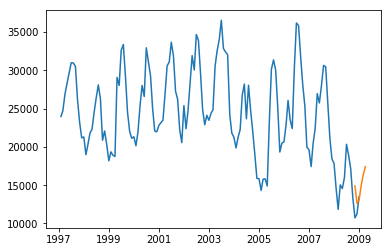

None
AVILA;AVILA II
0.02736808264160102


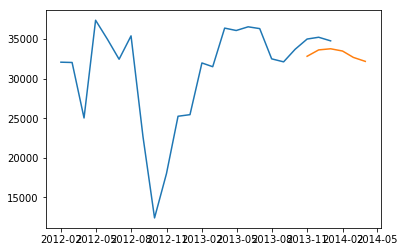

None
BURGOS;ARANDA DE DUERO
0.013381414928037922


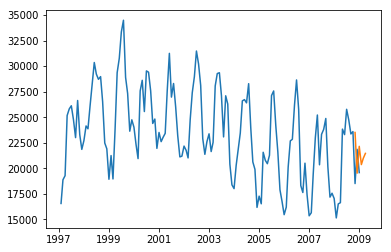

None
BURGOS;ARANDA DE DUERO 2
0.021213297955104436


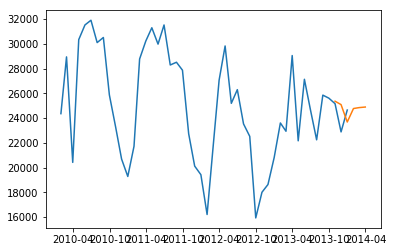

None
BURGOS;BURGOS 1
0.16084279204061197


/home/sandy/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


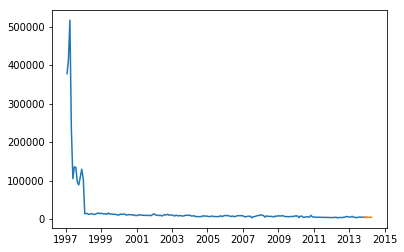

None
BURGOS;BURGOS 2
0.015306330446356901


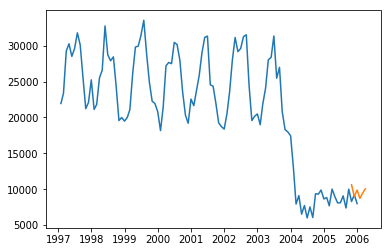

None
BURGOS;BURGOS 3
0.019633308451687058


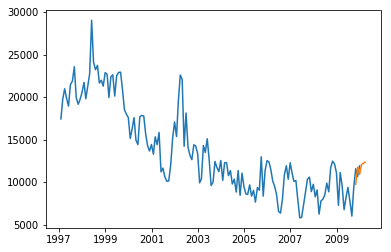

None
BURGOS;BURGOS 4
0.01590717177597069


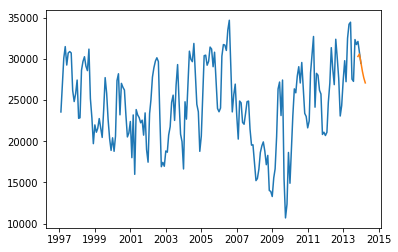

None
BURGOS;BURGOS 5
0.027474689400917456


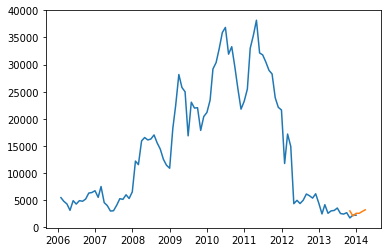

None
BURGOS;MEDINA DE POMAR
0.032032271994819256


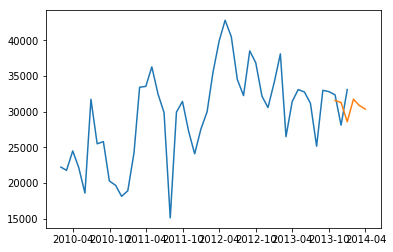

None
BURGOS;MIRANDA DE EBRO 1
0.025755569363135774


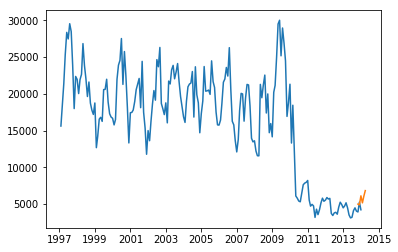

None
BURGOS;MIRANDA DE EBRO 2
0.022933754903626726


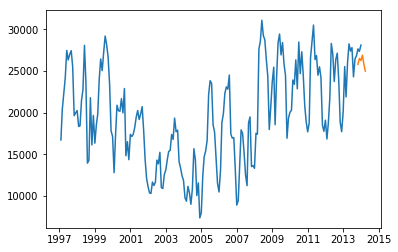

None
BURGOS;MIRANDA DE EBRO 3
0.027685686222920853


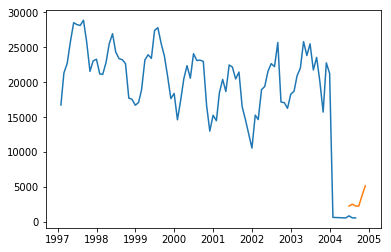

None
LEON;LA ROBLA
0.019967983444863193


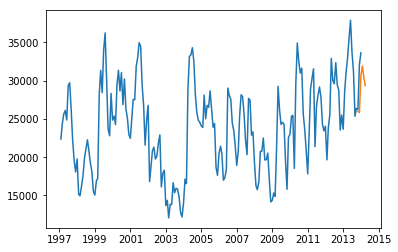

None
LEON;LARIO
0.024415550428277838


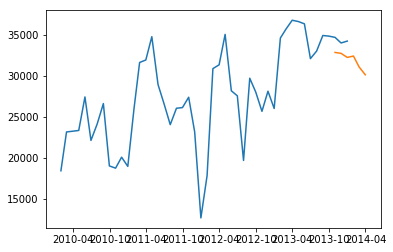

None
LEON;LEON 1
0.019569512777528573


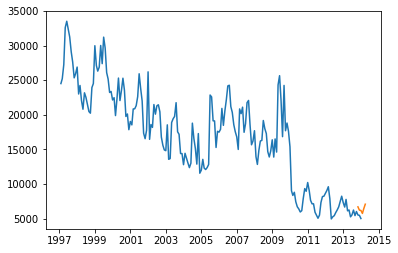

None
LEON;LEON 2
0.01461686201707017


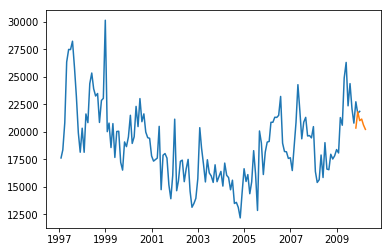

None
LEON;LEON 3
0.03188981964965045


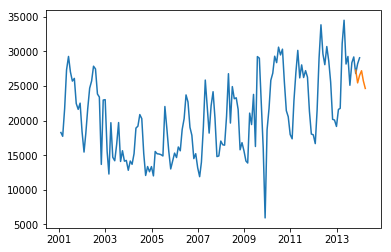

None
LEON;LEON 4
0.02237481076307234


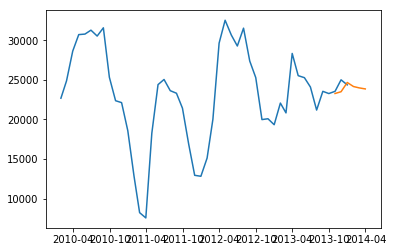

None
LEON;PONFERRADA 1
0.026008655645426818


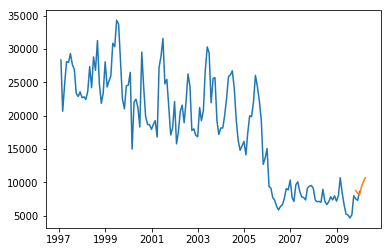

None
LEON;PONFERRADA 2
0.02722289402243089


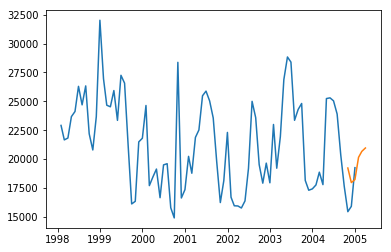

None
LEON;PONFERRADA 3
0.07123502474338855


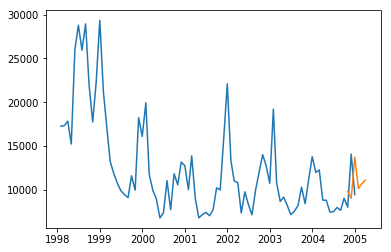

None
LEON;PONFERRADA 4
0.027567307713133513


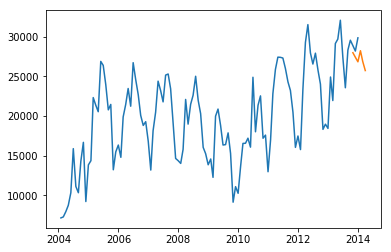

None
LEON;PONFERRADA 5
0.030508130803937474


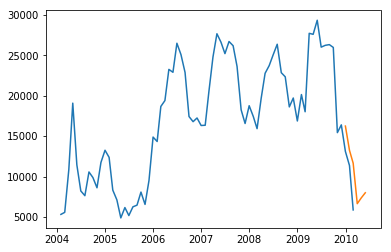

None
PALENCIA;GUARDO
0.015350257550009475


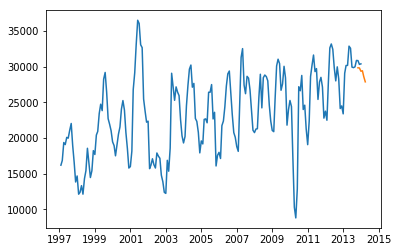

None
PALENCIA;PALENCIA 1
0.013527792627678427


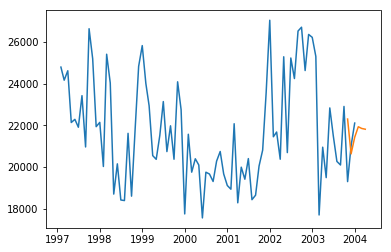

None
PALENCIA;PALENCIA 2
0.013271280808057225


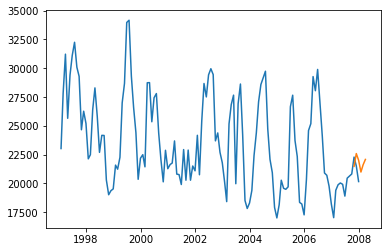

None
PALENCIA;PALENCIA 3
0.014980530896760795


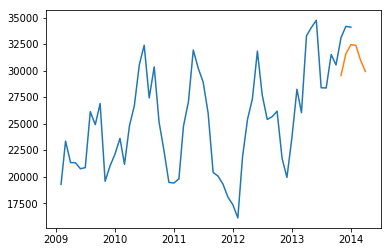

None
PALENCIA;VELILLA DEL RIO CARRION
0.015456573905262018


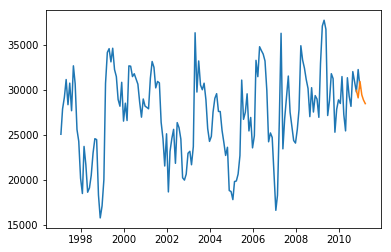

None
PALENCIA;VENTA DE BAIOS
0.014975703552128555


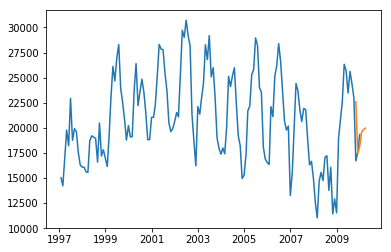

None
SALAMANCA;EL MAILLO
0.034571352182880884


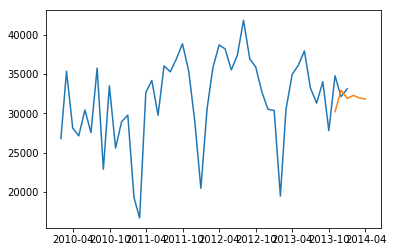

None
SALAMANCA;SALAMANCA 1
0.06208408839215462


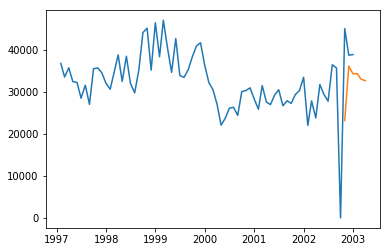

None
SALAMANCA;SALAMANCA 2
0.022236259514613214


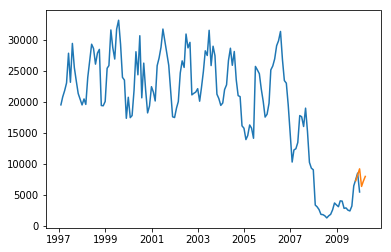

None
SALAMANCA;SALAMANCA 3
0.008513945246808808


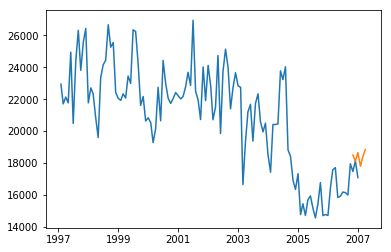

None
SALAMANCA;SALAMANCA 4
0.01981915225983856


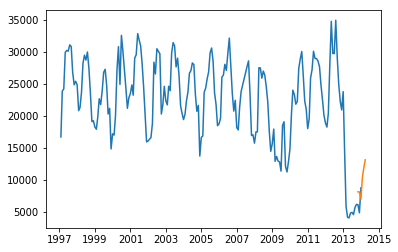

None
SALAMANCA;SALAMANCA 5
0.03402207125992046


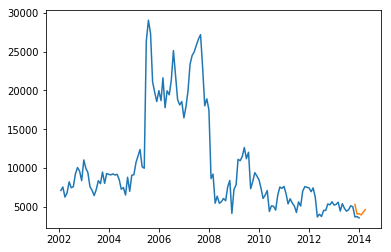

None
SALAMANCA;SALAMANCA 6
0.019797532888572583


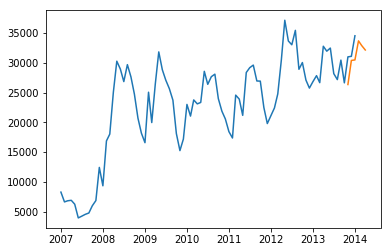

None
SEGOVIA;SEGOVIA 1
0.017526551311301642


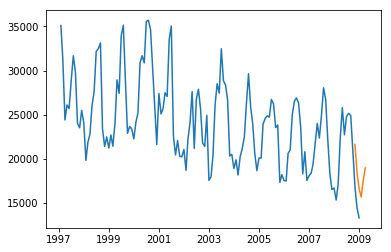

None
SEGOVIA;SEGOVIA 2
0.028243553707832426


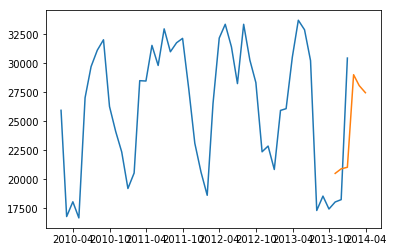

None
SORIA;MURIEL DE LA FUENTE
0.02901684103219532


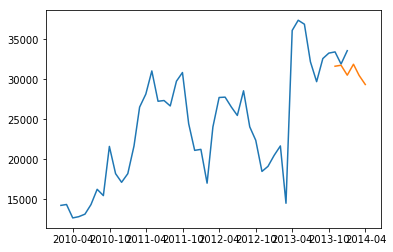

None
SORIA;SORIA
0.01858827178363467


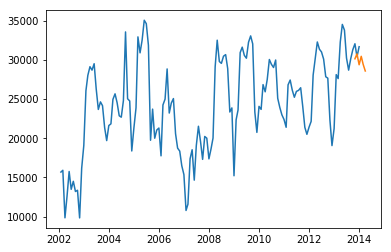

None
VALLADOLID;MEDINA DEL CAMPO
0.019622520537317854


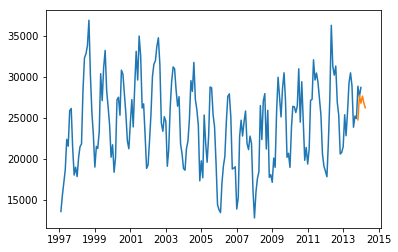

None
ZAMORA;ZAMORA 1
0.015289426125591024


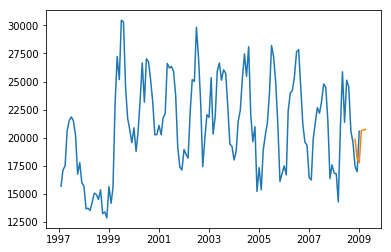

None
ZAMORA;ZAMORA 2
0.03360538945885504


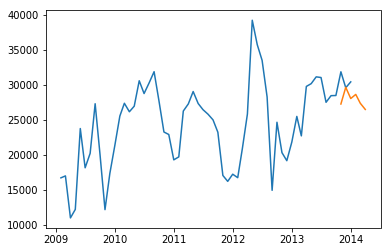

None


In [25]:

for i in proestunique:
    x = i.split(';')
    print(i)
    datos_por_provincia = datos[(datos['PROVINCIA'] == x[0]) & (datos['ESTACION'] == x[1])]
    #print(datos_por_provincia['IGCA'].describe())
    tdatos = datos_por_provincia['IGCA'].groupby(pd.Grouper(freq='M')).agg('mean')
    tdatos.interpolate(method='linear', inplace=True)
    print(sm.stats.durbin_watson(tdatos))
    model = ARIMA(tdatos, order=(1,0,0))
    model_fit = model.fit()
    #model = ARIMA(tsdTP , orsm.stats.durbin_watson(tsd)der=(1,0,0))
    #model_fit = model.fit()
    prediccion = model_fit.predict(start=tdatos.shape[0]-3, end=tdatos.shape[0]+2)
    plt.plot(tdatos)
    plt.plot(prediccion)
    print(plt.show())
    